In [3]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
# import os,sys
# from PIL import Image

from helpers import *
from sklearn import linear_model
from sklearn.metrics import confusion_matrix

%load_ext autoreload
%autoreload 2

In [4]:
try: 
    import cv2
except: 
    import pip
    pip.main(['install', 'opencv-python'])
    import cv2 

In [5]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

In [6]:
# Loaded a set of images
root_dir = "training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)

n = len(files)
imgs = [load_image(image_dir + files[i]) for i in range(n)]

gt_dir = root_dir + "groundtruth/"
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

print("Loading " + str(n) + " satellite + ground truth images")

Loading 100 satellite + ground truth images


In [7]:
# Extract patches from input images
patch_size = 16 # each patch is 16*16 pixels

img_patches = [img_crop(imgs[i], patch_size, patch_size) for i in range(n)]
gt_patches = [img_crop(gt_imgs[i], patch_size, patch_size) for i in range(n)]

# Linearize list of patches
img_patches = np.asarray([img_patches[i][j] for i in range(len(img_patches)) for j in range(len(img_patches[i]))])
gt_patches =  np.asarray([gt_patches[i][j] for i in range(len(gt_patches)) for j in range(len(gt_patches[i]))])


In [8]:
# Extract features
X = np.asarray([ extract_features(img_patches[i]) for i in range(len(img_patches))])

print("shape X[i] : {}".format(X[0].shape))

# Features augmentation 
X = features_augmentation(X)

# X = normalize(X)

# Print feature statistics
print('Computed ' + str(X.shape[0]) + ' features')
print('Feature dimension = ' + str(X.shape[1]))
# print('Number of classes = ' + str(np.max(Y)))


shape X[i] : (10,)
Computed 62500 features
Feature dimension = 11


In [9]:
def accuracy(labels, predictions):
    """ 
    input:  predictions - prediction array
            labels      - real labels array
    output: acc         - Accuracy: percentage of elements of predictions and labels that are the same
            PPV         - Positive Predictive Value, Precision
            TPR         - True Positive Rate, Sensitivity
    """
    
    conf_mat = confusion_matrix(labels, predictions)

    TN = conf_mat[0,0]
    FP = conf_mat[0,1]
    FN = conf_mat[1,0]
    TP = conf_mat[1,1]
    
    TPR = TP / (TP + FN)
    PPV = TP / (TP + FP)
    
    meanFscore = 2 * PPV * TPR / (PPV + TPR)
    F1 = 0
    
    acc = (TP + TN) / np.sum(conf_mat)
    
#     print("\nTPR = Sensitivity = {}".format(TPR))
#     print("PPV = Precision = {}".format(PPV))
#     print("Mean F Score = {}".format(meanFscore))
#     print("F1 overall = {}".format(F1))
    

    return acc

In [10]:
# Compute features for each image patch
# percentage of pixels > 1 required to assign a foreground label to a patch
foreground_threshold = np.arange(0.90, 0.92, 0.01) 

acc_threshold =[]

for threshold in foreground_threshold:
    def value_to_class(v):
        df = np.sum(v)
        if df > threshold:
            return 1
        else:
            return 0
    
    Y = np.asarray([value_to_class(np.mean(gt_patches[i])) for i in range(len(gt_patches))])
    

    Y0 = [i for i, j in enumerate(Y) if j == 0]
    Y1 = [i for i, j in enumerate(Y) if j == 1]
#     print('Class 0: ' + str(len(Y0)) + ' samples')
#     print('Class 1: ' + str(len(Y1)) + ' samples')

    # Train a logistic regression classifier
    # TODO: - For loop on C parameter
    #       - penalty in LogisticRegression?

    # we create an instance of the classifier and fit the data
    logreg = linear_model.LogisticRegression(C=1e5, class_weight="balanced")
    logreg.fit(X, Y)
    
    # Predict on the training set
    Z = logreg.predict(X)

#     # Get non-zeros in prediction and grountruth arrays
#     Zn = np.nonzero(Z)[0]
#     Yn = np.nonzero(Y)[0]

#     TPR = len(list(set(Yn) & set(Zn))) / float(len(Z))
#     print('True positive rate = ' + str(TPR))

    acc = accuracy(labels = Y, predictions = Z)
    acc_threshold.append(acc)
    
    print("Foreground threshold = {}".format(threshold))
    print("Accuracy: {}".format(acc))


Foreground threshold = 0.9
Accuracy: 0.635632
Foreground threshold = 0.91
Accuracy: 0.637024
Foreground threshold = 0.92
Accuracy: 0.638256


In [11]:
# Get best parameter
ind_max = np.argmax(acc_threshold)
opt_threshold = foreground_threshold[ind_max]
print(opt_threshold)

0.92


In [12]:
# Data to evaluate
root_testdir = "test_set_images"
test_names = os.listdir(root_testdir)

num_test = len(test_names)
imgs_test = [load_image(os.path.join(root_testdir, test_names[i], test_names[i]) + ".png") for i in range(num_test)]

img_patches_test = [img_crop(imgs_test[i], patch_size, patch_size) for i in range(num_test)]
# Linearize list of patches
img_patches_test = np.asarray([img_patches_test[i][j] for i in range(len(img_patches_test)) for j in range(len(img_patches_test[i]))])


X_test = np.asarray([ extract_features(img_patches_test[i]) for i in range(len(img_patches_test))])
X_test = features_augmentation(X_test)

# X_test = normalize(X_test)

# Run prediction
Z_test = logreg.predict(X_test)


# Save prediction
create_submission(Z_test, "submission_priscille.csv")




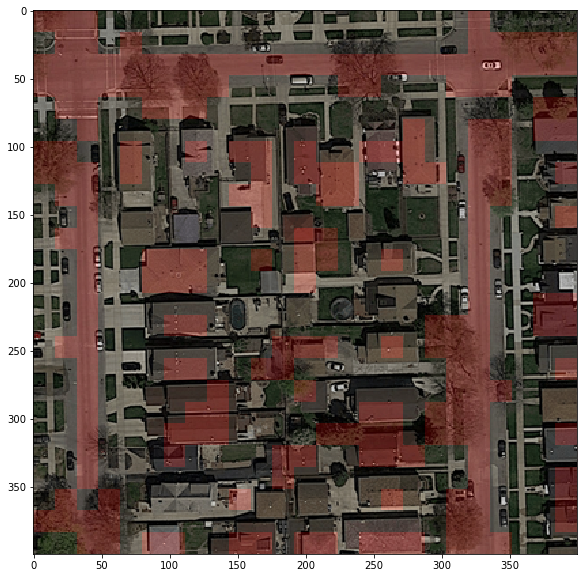

In [16]:
import random 
patch_size = 16

# Run prediction on the img_idx-th image
img_idx = random.randint(0,99)
patch_size = 16
Xi = extract_img_features(image_dir + files[img_idx])
Xi = features_augmentation(Xi)
Zi = logreg.predict(Xi)

# Display prediction as an image
w = gt_imgs[img_idx].shape[0]
h = gt_imgs[img_idx].shape[1]
predicted_im = label_to_img(w, h, patch_size, patch_size, Zi)
cimg = concatenate_images(imgs[img_idx], predicted_im)
fig1 = plt.figure(figsize=(10, 10)) # create a figure with the default size 
plt.imshow(cimg, cmap='Greys_r')

new_img = make_img_overlay(imgs[img_idx], predicted_im)

plt.imshow(new_img)